In [1]:
import json
import random
import boto3
from botocore.exceptions import ClientError

import sagemaker
from sagemaker.pytorch import PyTorch

import os
import boto3
import tarfile

import os
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2


# === S3 Bucket and Key Configuration ===
BUCKET_NAME = "sagemaker-studio-781388202187-bjh9kcrt4r4"  # Your S3 bucket name
# Original JSON file location (with COCO annotations)
JSON_KEY = "lemon-dataset/annotations/instances_default.json"
# Original images are stored under this prefix in the bucket
ORIGINAL_IMAGE_PREFIX = "lemon-dataset/images/"


# Last Minute Preprocessing

In [ ]:
# Initialize the S3 client.
s3 = boto3.client('s3')

# === Helper Functions ===
def download_json_from_s3(bucket, key, local_path="annotations.json"):
    """Download the JSON annotation file from S3."""
    s3.download_file(bucket, key, local_path)
    return local_path

def delete_all_objects_with_prefix(bucket, prefix):
    """Delete all objects in the specified S3 bucket that start with the given prefix."""
    paginator = s3.get_paginator('list_objects_v2')
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        if "Contents" in page:
            objects_to_delete = [{"Key": obj["Key"]} for obj in page["Contents"]]
            s3.delete_objects(Bucket=bucket, Delete={"Objects": objects_to_delete})
            print(f"Deleted {len(objects_to_delete)} objects under {prefix}")

def copy_s3_object(bucket, source_key, dest_key):
    """Copy an object within the same bucket."""
    try:
        copy_source = {"Bucket": bucket, "Key": source_key}
        s3.copy_object(Bucket=bucket, CopySource=copy_source, Key=dest_key)
        print(f"Copied {source_key} to {dest_key}")
    except ClientError as e:
        print(f"Error copying {source_key} to {dest_key}: {e}")

def get_source_key(file_name):
    """
    Compute the source key for an image in the original images folder.
    Since we already removed the "images/" prefix from file_name,
    simply prepend the ORIGINAL_IMAGE_PREFIX.
    """
    return ORIGINAL_IMAGE_PREFIX + file_name

In [2]:
# Define the output folder structure in S3
SUBSET_ROOT = "image_subset/"

# "allsubset" will contain all filtered images and annotations.
ALLSUBSET_PREFIX = SUBSET_ROOT + "allsubset/"
ALLSUBSET_IMAGES_PREFIX = ALLSUBSET_PREFIX + "images/"

# Each split folder will contain its own images subfolder and annotations.
TRAIN_PREFIX = SUBSET_ROOT + "train/"
TRAIN_IMAGES_PREFIX = TRAIN_PREFIX + "images/"
VAL_PREFIX   = SUBSET_ROOT + "val/"
VAL_IMAGES_PREFIX = VAL_PREFIX + "images/"
TEST_PREFIX  = SUBSET_ROOT + "test/"
TEST_IMAGES_PREFIX = TEST_PREFIX + "images/"

In [4]:
# === STEP 0: Clear Existing Data Under SUBSET_ROOT in S3 ===
print("Clearing existing objects under the subset root in S3...")
delete_all_objects_with_prefix(BUCKET_NAME, SUBSET_ROOT)

# === STEP 1: Download and Update the Original Annotations JSON ===
local_annotations_file = download_json_from_s3(BUCKET_NAME, JSON_KEY, "annotations.json")
with open(local_annotations_file, 'r') as f:
    data = json.load(f)

# Strip "images/" prefix from all image file names in the annotations.
for img in data.get("images", []):
    file_name = img.get("file_name", "")
    if file_name.startswith("images/"):
        img["file_name"] = file_name[len("images/"):]

Clearing existing objects under the subset root in S3...


In [5]:

# Save the updated annotations locally (if needed later)
with open("annotations_updated.json", "w") as f:
    json.dump(data, f)
print("Stripped 'images/' prefix from all image file names in the annotations.")


Stripped 'images/' prefix from all image file names in the annotations.


In [6]:
# === STEP 2: Filter Images and Annotations ===
# Identify category IDs for "mould" and "pedicel" (case-insensitive)
mould_cat_ids = [cat["id"] for cat in data["categories"] if cat["name"].lower() == "mould"]
pedicel_cat_ids = [cat["id"] for cat in data["categories"] if cat["name"].lower() == "pedicel"]

if not mould_cat_ids:
    raise ValueError("No category named 'mould' found in annotations.")
if not pedicel_cat_ids:
    print("Warning: No category named 'pedicel' found; only 'mould' annotations will be kept.")
# Select images that contain at least one "mould" annotation.
mould_image_ids = {ann["image_id"] for ann in data["annotations"] if ann["category_id"] in mould_cat_ids}
filtered_images = [img for img in data["images"] if img["id"] in mould_image_ids]

# Filter annotations: keep only for images with mould, remove boxes with area < 150,
# and keep only those with category "mould" or "pedicel".
filtered_annotations = []
for ann in data["annotations"]:
    if ann["image_id"] not in mould_image_ids:
        continue
    if ann["area"] < 150:
        continue
    if ann["category_id"] not in (mould_cat_ids + pedicel_cat_ids):
        continue
    filtered_annotations.append(ann)

# Update the categories list accordingly.
new_categories = [cat for cat in data["categories"] if cat["id"] in (mould_cat_ids + pedicel_cat_ids)]

# Create the complete filtered dataset.
allsubset_data = {
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": new_categories
}


In [7]:
# === STEP 3: Upload the "allsubset" Data to S3 ===
local_allsubset_json = "allsubset_annotations.json"
with open(local_allsubset_json, 'w') as f:
    json.dump(allsubset_data, f)
allsubset_annotations_key = ALLSUBSET_PREFIX + "annotations.json"
s3.upload_file(local_allsubset_json, BUCKET_NAME, allsubset_annotations_key)
print(f"Uploaded allsubset annotations to s3://{BUCKET_NAME}/{allsubset_annotations_key}")

# Copy all filtered images to the allsubset/images/ folder.
print("Copying all filtered images to allsubset/images/ in S3...")
for img in filtered_images:
    source_key = get_source_key(img["file_name"])
    dest_key = ALLSUBSET_IMAGES_PREFIX + img["file_name"]
    copy_s3_object(BUCKET_NAME, source_key, dest_key)


Uploaded allsubset annotations to s3://sagemaker-studio-781388202187-bjh9kcrt4r4/image_subset/allsubset/annotations.json
Copying all filtered images to allsubset/images/ in S3...
Copied lemon-dataset/images/0004_B_H_0_G.jpg to image_subset/allsubset/images/0004_B_H_0_G.jpg
Copied lemon-dataset/images/0004_B_H_0_H.jpg to image_subset/allsubset/images/0004_B_H_0_H.jpg
Copied lemon-dataset/images/0004_B_H_15_G.jpg to image_subset/allsubset/images/0004_B_H_15_G.jpg
Copied lemon-dataset/images/0004_B_H_15_H.jpg to image_subset/allsubset/images/0004_B_H_15_H.jpg
Copied lemon-dataset/images/0004_B_H_30_G.jpg to image_subset/allsubset/images/0004_B_H_30_G.jpg
Copied lemon-dataset/images/0004_B_H_45_G.jpg to image_subset/allsubset/images/0004_B_H_45_G.jpg
Copied lemon-dataset/images/0004_B_H_45_H.jpg to image_subset/allsubset/images/0004_B_H_45_H.jpg
Copied lemon-dataset/images/0015_B_I_15_A.jpg to image_subset/allsubset/images/0015_B_I_15_A.jpg
Copied lemon-dataset/images/0016_B_I_0_A.jpg to i

In [8]:
# === STEP 4: Split the Dataset into Train (40%), Val (30%), and Test (30%) ===
random.shuffle(filtered_images)
n = len(filtered_images)
n_train = int(0.4 * n)
n_val   = int(0.3 * n)
train_images = filtered_images[:n_train]
val_images   = filtered_images[n_train:n_train+n_val]
test_images  = filtered_images[n_train+n_val:]
print(f"Dataset split: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test images.")

def create_split_annotation(split_images):
    """Create an annotation JSON for a split containing only images in that split."""
    split_ids = {img["id"] for img in split_images}
    split_annotations = [ann for ann in filtered_annotations if ann["image_id"] in split_ids]
    return {
        "images": split_images,
        "annotations": split_annotations,
        "categories": new_categories
    }

def copy_split_images(split_images, dest_images_prefix):
    """Copy images for a split into the designated images subfolder in S3."""
    for img in split_images:
        source_key = ALLSUBSET_IMAGES_PREFIX + img["file_name"]  # Use images from the allsubset folder.
        dest_key = dest_images_prefix + img["file_name"]
        copy_s3_object(BUCKET_NAME, source_key, dest_key)

# For each split, copy images and upload split-specific annotations.
for split_name, split_images, split_prefix, split_images_prefix in [
    ("train", train_images, TRAIN_PREFIX, TRAIN_IMAGES_PREFIX),
    ("val",   val_images,   VAL_PREFIX,   VAL_IMAGES_PREFIX),
    ("test",  test_images,  TEST_PREFIX,  TEST_IMAGES_PREFIX)
]:
    print(f"Processing {split_name} split...")
    # Copy images to the split's images folder.
    copy_split_images(split_images, split_images_prefix)
    
    # Create and upload the split-specific annotations JSON.
    split_data = create_split_annotation(split_images)
    local_split_json = f"{split_name}_annotations.json"
    with open(local_split_json, 'w') as f:
        json.dump(split_data, f)
    split_annotations_key = split_prefix + "annotations.json"
    s3.upload_file(local_split_json, BUCKET_NAME, split_annotations_key)
    print(f"Uploaded {split_name} annotations to s3://{BUCKET_NAME}/{split_annotations_key}")

Dataset split: 105 train, 79 val, 80 test images.
Processing train split...
Copied image_subset/allsubset/images/0020_G_I_120_[F.jpg to image_subset/train/images/0020_G_I_120_[F.jpg
Copied image_subset/allsubset/images/0023_G_H_0_F.jpg to image_subset/train/images/0023_G_H_0_F.jpg
Copied image_subset/allsubset/images/0012_G_I_60_F.jpg to image_subset/train/images/0012_G_I_60_F.jpg
Copied image_subset/allsubset/images/0016_B_I_120_A.jpg to image_subset/train/images/0016_B_I_120_A.jpg
Copied image_subset/allsubset/images/0012_G_V_120_F.jpg to image_subset/train/images/0012_G_V_120_F.jpg
Copied image_subset/allsubset/images/0013_G_H_120_F.jpg to image_subset/train/images/0013_G_H_120_F.jpg
Copied image_subset/allsubset/images/0019_G_V_120_F.jpg to image_subset/train/images/0019_G_V_120_F.jpg
Copied image_subset/allsubset/images/0019_G_I_60_F.jpg to image_subset/train/images/0019_G_I_60_F.jpg
Copied image_subset/allsubset/images/0019_G_I_30_F.jpg to image_subset/train/images/0019_G_I_30_F.

In [11]:


# Configuration: update these values as needed.
BUCKET_NAME = "sagemaker-studio-781388202187-bjh9kcrt4r4"
TRAIN_ANNOTATIONS_KEY = "image_subset/train/annotations.json"

# Initialize the S3 client.
s3 = boto3.client('s3')

# Download the train annotations JSON from S3.
response = s3.get_object(Bucket=BUCKET_NAME, Key=TRAIN_ANNOTATIONS_KEY)
annotations_data = json.loads(response['Body'].read().decode('utf-8'))

def get_box_array(box_list):
    """
    Convert a list of bounding boxes to a numpy array with shape (N, 4).
    If the list is empty, return an empty array with shape (0, 4).
    """
    if not box_list:
        return np.zeros((0, 4), dtype=np.float32)
    return np.array(box_list, dtype=np.float32)

# Build a dictionary mapping each image ID to its list of bounding boxes.
image_id_to_boxes = {}

# Initialize each image entry with an empty list.
for image in annotations_data.get("images", []):
    image_id = image.get("id")
    image_id_to_boxes[image_id] = []

# Populate the dictionary with bounding boxes from annotations.
for ann in annotations_data.get("annotations", []):
    image_id = ann.get("image_id")
    bbox = ann.get("bbox")
    # Assuming each annotation contains a "bbox" key.
    if bbox is not None:
        image_id_to_boxes[image_id].append(bbox)

# Convert lists of boxes to numpy arrays with the expected shape.
for image_id, boxes in image_id_to_boxes.items():
    boxes_array = get_box_array(boxes)
    # Log the shape of the boxes array for each image.
    print(f"Image ID {image_id}: Boxes array shape: {boxes_array.shape}")
    # Optionally, you can check for any image that ends up with shape (0,) incorrectly.
    # For safety, you might want to assert that the array always has two dimensions.
    assert boxes_array.ndim == 2 and boxes_array.shape[1] == 4, \
        f"Image ID {image_id} has invalid box dimensions: {boxes_array.shape}"

Image ID 6029: Boxes array shape: (1, 4)
Image ID 6095: Boxes array shape: (1, 4)
Image ID 5770: Boxes array shape: (1, 4)
Image ID 1686: Boxes array shape: (1, 4)
Image ID 5775: Boxes array shape: (1, 4)
Image ID 5787: Boxes array shape: (2, 4)
Image ID 6008: Boxes array shape: (1, 4)
Image ID 6004: Boxes array shape: (1, 4)
Image ID 6002: Boxes array shape: (1, 4)
Image ID 6098: Boxes array shape: (1, 4)
Image ID 5700: Boxes array shape: (1, 4)
Image ID 5733: Boxes array shape: (3, 4)
Image ID 6030: Boxes array shape: (1, 4)
Image ID 5717: Boxes array shape: (1, 4)
Image ID 6085: Boxes array shape: (1, 4)
Image ID 5489: Boxes array shape: (1, 4)
Image ID 6009: Boxes array shape: (1, 4)
Image ID 1396: Boxes array shape: (1, 4)
Image ID 6501: Boxes array shape: (1, 4)
Image ID 6059: Boxes array shape: (1, 4)
Image ID 6080: Boxes array shape: (1, 4)
Image ID 5794: Boxes array shape: (1, 4)
Image ID 5446: Boxes array shape: (2, 4)
Image ID 6046: Boxes array shape: (1, 4)
Image ID 1399: B

# Model Training

In [39]:

# Set your bucket name.
BUCKET_NAME = "sagemaker-studio-781388202187-bjh9kcrt4r4"

# Get the SageMaker execution role and session.
role = sagemaker.get_execution_role()
session = sagemaker.Session()

# Create a PyTorch estimator for your Mask R-CNN training script.
estimator = PyTorch(
    entry_point="train_lemon_maskrcnn.py",  # Your training script
    source_dir="/home/sagemaker-user/src",   # Directory containing train_lemon_maskrcnn.py and related files
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",          # Using GPU-enabled instance for training
    framework_version="1.13",
    py_version="py39",                       # Supported Python version
    hyperparameters={
        "max_iter": 10000,       # Number of training iterations
        "lr": 0.001,             # Base learning rate
        # You can add more hyperparameters as needed.
    },
    output_path=f"s3://{BUCKET_NAME}/output"   # S3 folder where the training job output will be stored
)

# Define S3 input channels.
# This example assumes your S3 bucket contains your dataset under the "image_subset" prefix.
inputs = {
    "training": f"s3://{BUCKET_NAME}/image_subset"
}

# Launch the training job and stream logs to the notebook.
estimator.fit(inputs, logs=True)


[04/04/25 20:28:44] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=637246;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=561556;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=981991;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=33117;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=249142;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=538963;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=185186;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=67730;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2025-04-04-20-28-44-761                                              

2025-04-04 20:28:46 Starting - Starting the training job...
..25-04-04 20:29:01 Starting - Preparing the instances for training.
..25-04-04 20:29:29 Downloading - Downloading input data.
..............29:59 Downloading - Downloading the training image.
.bash: cannot set terminal process group (-1): Inappropriate ioctl for device..
bash: no job control in this shell
/opt/conda/lib/python3.9/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.9/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
2025-04-04 20:32:59,141 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container

In [42]:
!pip install opencv-python


In [43]:
!pip install opencv-python-headless


In [44]:
!apt-get update && apt-get install -y libgl1-mesa-glx

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/


In [46]:
+++++++

# S3 configuration
s3_bucket = "sagemaker-studio-781388202187-bjh9kcrt4r4"
s3_key = "output/pytorch-training-2025-04-04-20-28-44-761/output/model.tar.gz"
local_tar_path = "model.tar.gz"

# Initialize the S3 client and download the model artifact
s3 = boto3.client("s3")
print("Downloading model artifact from S3...")
s3.download_file(s3_bucket, s3_key, local_tar_path)
print(f"Downloaded artifact to {local_tar_path}")

# Define a directory to extract the model artifact
extract_dir = "model_artifact"
os.makedirs(extract_dir, exist_ok=True)

print("Extracting the model artifact...")
with tarfile.open(local_tar_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)
print(f"Model artifact extracted to {extract_dir}")

# Construct the full path to the model weights file
model_path = os.path.join(extract_dir, "maskrcnn_lemon.pth")
if os.path.exists(model_path):
    print("Found model file at:", model_path)
else:
    raise FileNotFoundError(f"Model file not found at {model_path}")

Downloaded artifact to model.tar.gz
Extracting the model artifact...
Model artifact extracted to model_artifact
Found model file at: model_artifact/maskrcnn_lemon.pth


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_1260/14432588.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

[{'boxes': tensor([[318.5252, 595.4274, 388.1599, 673.0257],
        [388.1076, 340.8596, 550.8831, 384.0621],
        [212.2790, 390.8965, 449.4214, 784.1857],
        [319.8284, 619.0615, 346.8122, 659.8562],
        [285.6530, 595.0193, 369.0436, 670.4393],
        [317.4618, 612.7296, 360.4597, 668.0192],
        [423.1215, 343.6181, 521.5773, 366.6464],
        [121.5894, 358.6337, 346.0094, 774.4626],
        [233.5276, 375.6379, 708.5214, 554.7725],
        [427.8530, 340.1187, 594.6360, 374.4017],
        [290.1381, 521.8981, 308.8251, 560.8196],
        [201.2256, 356.6361, 577.2036, 668.4491],
        [314.9064, 597.5827, 383.5970, 668.9232],
        [306.9316, 561.1739, 398.7325, 717.3767],
        [450.3397, 342.7439, 547.6497, 363.3270],
        [374.4474, 339.9432, 618.7586, 408.1969],
        [288.3581, 582.8260, 424.7375, 682.3323],
        [301.1421, 343.0709, 585.8043, 437.6286],
        [242.2700, 589.5823, 385.0004, 700.1574],
        [415.5711, 346.2800, 485.7197, 

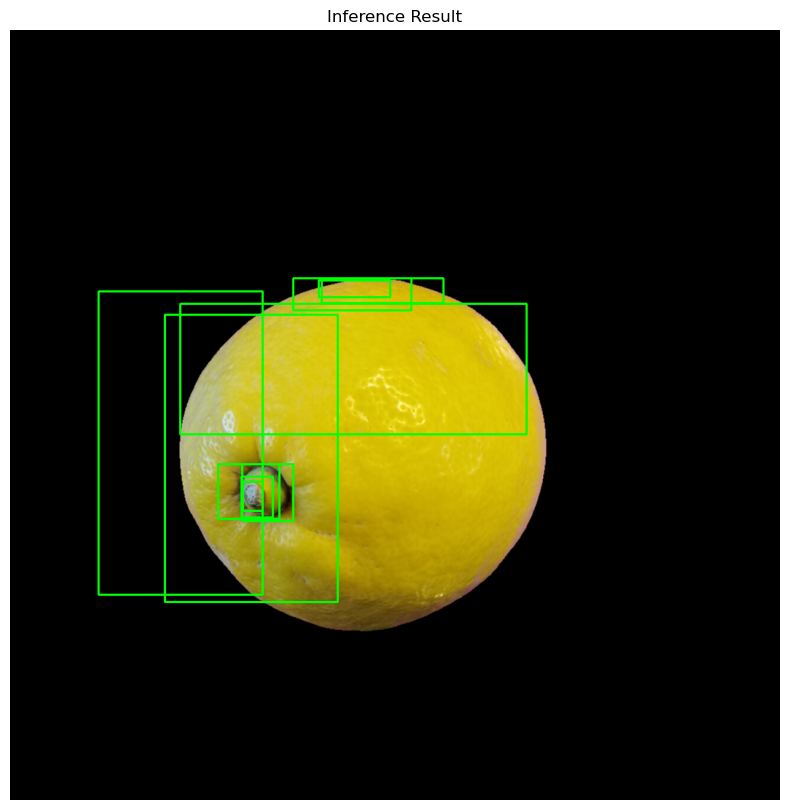

In [62]:


model_path = "model_artifact/maskrcnn_lemon.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()

# Define a simple transform
transform = T.Compose([T.ToTensor()])

def visualize_prediction(image_path, model, transform, score_threshold=0.5):
    # Load the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image)
    
    # Run inference
    with torch.no_grad():
        predictions = model([image_tensor])
    print(predictions)
    
    # Convert image to numpy for visualization
    image_np = np.array(image)
    for i, score in enumerate(predictions[0]['scores']):
        if score > score_threshold:
            box = predictions[0]['boxes'][i].cpu().numpy().astype(int)
            cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
    plt.figure(figsize=(10,10))
    plt.imshow(image_np)
    plt.title("Inference Result")
    plt.axis("off")
    plt.show()

# Replace with the path to your test image
test_image_path = "/home/sagemaker-user/ADS-508/Lemon-testDS/healthy.png"
visualize_prediction(test_image_path, model, transform)

In [52]:
import os
import torch

# Use SM_MODEL_DIR if set; otherwise, default to a local "model" folder.
model_dir = os.environ.get("SM_MODEL_DIR", "./model")
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

model_path = os.path.join(model_dir, "maskrcnn_lemon.pth")
torch.save(model.state_dict(), model_path)
print("Model saved to", model_path)


Model saved to ./model/maskrcnn_lemon.pth


In [60]:

# Define a basic transformation (must match your training transforms).
transform = T.Compose([T.ToTensor()])

# Load your test image. Replace the path with your actual test image file.
test_image_path = "/home/sagemaker-user/ADS-508/Lemon-testDS/healthy.png"  # update this path

# Open the image and convert it to RGB.
image = Image.open(test_image_path).convert("RGB")
# Apply the transformation to get an image tensor.
image_tensor = transform(image)

# Run inference on the image.
model.eval()  # make sure the model is in evaluation mode
with torch.no_grad():
    predictions = model([image_tensor])

# Print raw predictions.
print("Boxes:", predictions[0]["boxes"])
print("Scores:", predictions[0]["scores"])
print("Labels:", predictions[0]["labels"])


Boxes: tensor([[318.5252, 595.4274, 388.1599, 673.0257],
        [388.1076, 340.8596, 550.8831, 384.0621],
        [212.2790, 390.8965, 449.4214, 784.1857],
        [319.8284, 619.0615, 346.8122, 659.8562],
        [285.6530, 595.0193, 369.0436, 670.4393],
        [317.4618, 612.7296, 360.4597, 668.0192],
        [423.1215, 343.6181, 521.5773, 366.6464],
        [121.5894, 358.6337, 346.0094, 774.4626],
        [233.5276, 375.6379, 708.5214, 554.7725],
        [427.8530, 340.1187, 594.6360, 374.4017],
        [290.1381, 521.8981, 308.8251, 560.8196],
        [201.2256, 356.6361, 577.2036, 668.4491],
        [314.9064, 597.5827, 383.5970, 668.9232],
        [306.9316, 561.1739, 398.7325, 717.3767],
        [450.3397, 342.7439, 547.6497, 363.3270],
        [374.4474, 339.9432, 618.7586, 408.1969],
        [288.3581, 582.8260, 424.7375, 682.3323],
        [301.1421, 343.0709, 585.8043, 437.6286],
        [242.2700, 589.5823, 385.0004, 700.1574],
        [415.5711, 346.2800, 485.7197, 369.